In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.silence import split_on_silence
import soundfile as sf
import sounddevice as sd
import datetime

%matplotlib inline
%config InlineBackend.figure_format = "retina"

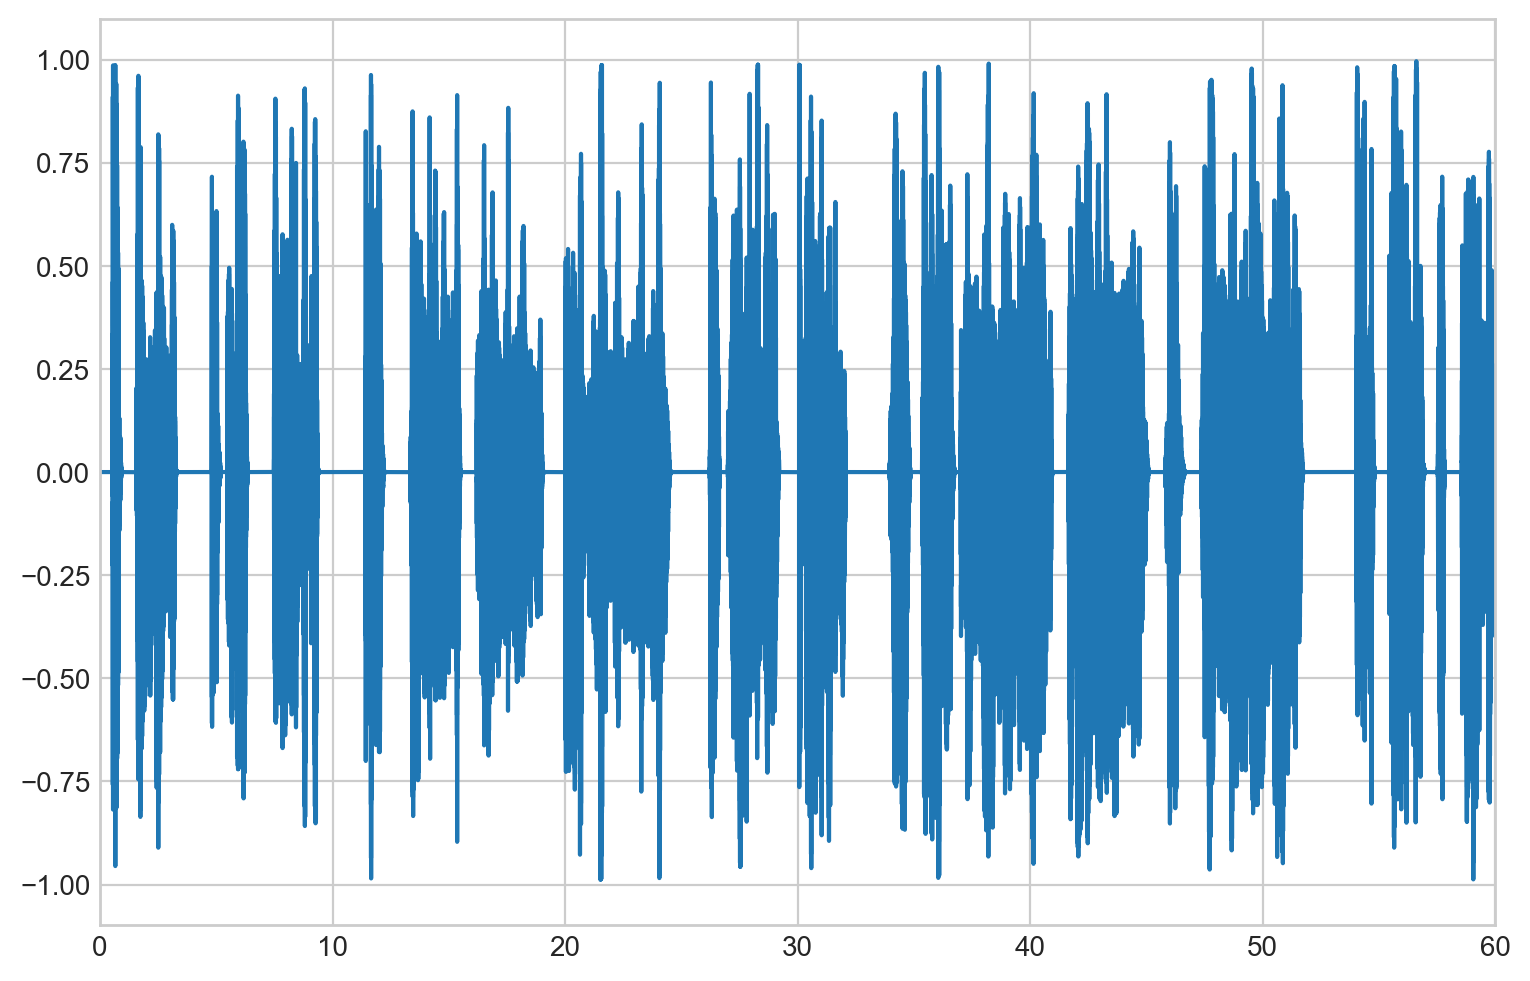

In [27]:
# load audio
data, fs = sf.read('./data/Track 2.wav', dtype='float32')
time = np.linspace(0, len(data) / fs, num=len(data))

# creat channel name
prefix = 'channel_'
n_channels = data.shape[1]
n_str = np.arange(1, n_channels + 1, 1, dtype=str)
channels = [prefix + i for i in n_str]

# convert to pandas df
pd_data = pd.DataFrame(data, columns=channels)
pd_data['seconds'] = time

fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.plot(pd_data['seconds'], pd_data['channel_1'])

ax.set_xlim([0, 60])
plt.rc("figure", dpi=100)
plt.style.use("seaborn-whitegrid")
plt.show()

In [31]:
audio = AudioSegment.from_wav('./data/Track 2.wav')
chunks = split_on_silence(audio, min_silence_len = 1000)

In [32]:
chunks

In [124]:
# str(datetime.timedelta(seconds=65066))
# apt-get install ffmpeg libavcodec-extra

'18:04:26'